In [56]:
import os
from typing import *
import operator

from dotenv import load_dotenv
load_dotenv()
from IPython.display import Image, display
import sqlite3


from langchain_ollama import ChatOllama
from langchain_together import ChatTogether
from langchain_huggingface import HuggingFaceEndpoint,ChatHuggingFace
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt

In [68]:
# ------------------------------------------------------ #
# GLOBALS
# ------------------------------------------------------ #
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [58]:
# ------------------------------------------------------ #
# TOOLS
# ------------------------------------------------------ #


In [59]:
# ------------------------------------------------------ #
# MODELS
# ------------------------------------------------------ #
# chat_llm = ChatTogether(model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free", api_key=TOGETHER_API_KEY)
chat_llm = ChatOllama(model='llama3.2:latest')
# tools = [add, multiply, divide]
# llm_with_tools = chat_llm.bind_tools(tools)

In [60]:
# ------------------------------------------------------ #
# REDUCERS
# ------------------------------------------------------ #
def sorting_reducer(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return sorted(left + right, reverse=False)

In [61]:
# ------------------------------------------------------ #
# STATE
# ------------------------------------------------------ #
# class State(TypedDict):
#     state: str

class State(TypedDict):
    state: Annotated[list, sorting_reducer]

In [62]:
# ------------------------------------------------------ #
# NODES
# ------------------------------------------------------ #
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Reassigning <<{self._value}>> to {state['state']}")
        return {'state': [self._value]}

In [63]:
# ------------------------------------------------------ #
# CONDITIONAL EDGES
# ------------------------------------------------------ #


In [64]:
# ------------------------------------------------------ #
# MEMORY
# ------------------------------------------------------ #
memory = MemorySaver()

In [65]:
# ------------------------------------------------------ #
# WORKFLOWS
# ------------------------------------------------------ #
def workflow_simple():
    builder = StateGraph(State)
    # node
    builder.add_node("a", ReturnNodeValue("I'm A"))
    builder.add_node("b", ReturnNodeValue("I'm B"))
    builder.add_node("c", ReturnNodeValue("I'm C"))
    builder.add_node("d", ReturnNodeValue("I'm D"))
    # edge
    builder.add_edge(START, "a")
    builder.add_edge("a", "b")
    builder.add_edge("b", "c")
    builder.add_edge("c", "d")
    builder.add_edge("d", END)
    return builder

def workflow_fan_out():
    builder = StateGraph(State)
    # node
    builder.add_node("a", ReturnNodeValue("I'm A"))
    builder.add_node("b", ReturnNodeValue("I'm B"))
    builder.add_node("c", ReturnNodeValue("I'm C"))
    builder.add_node("d", ReturnNodeValue("I'm D"))
    # edge
    builder.add_edge(START, "a")
    builder.add_edge("a", "b")
    builder.add_edge("a", "c")
    builder.add_edge("b", "d")
    builder.add_edge("c", "d")
    builder.add_edge("d", END)
    return builder


def workflow_waiting():
    builder = StateGraph(State)
    # nodes
    builder.add_node("a", ReturnNodeValue("I'm A"))
    builder.add_node("b", ReturnNodeValue("I'm B"))
    builder.add_node("b2", ReturnNodeValue("I'm B2"))
    builder.add_node("c", ReturnNodeValue("I'm C"))
    builder.add_node("d", ReturnNodeValue("I'm D"))
    # edges
    builder.add_edge(START, "a")
    builder.add_edge("a", "b")
    builder.add_edge("a", "c")
    builder.add_edge("b", "b2")
    builder.add_edge(["b2", "c"], "d")
    builder.add_edge("d", END)
    return builder

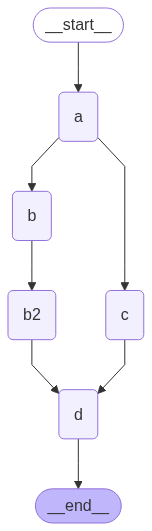

In [66]:
# ------------------------------------------------------ #
# COMPILE GRAPH
# ------------------------------------------------------ #
# workflow = workflow_simple()
# workflow = workflow_fan_out()
workflow = workflow_waiting()
graph = workflow.compile()
# graph = workflow.compile()
# print(graph.get_graph().draw_ascii())
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
graph.invoke({'state': []})

Reassigning <<I'm A>> to []
Reassigning <<I'm C>> to ["I'm A"]
Reassigning <<I'm B>> to ["I'm A"]
Reassigning <<I'm B2>> to ["I'm A", "I'm B", "I'm C"]
Reassigning <<I'm D>> to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

---

---

---

---

---

---

---

---

---

---

---

---

---

---

In [69]:
# ------------------------------------------------------ #
# STATE
# ------------------------------------------------------ #
# class State(TypedDict):
#     state: str

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, sorting_reducer]